In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

==============================linear-fstw
(50, 4, 4)


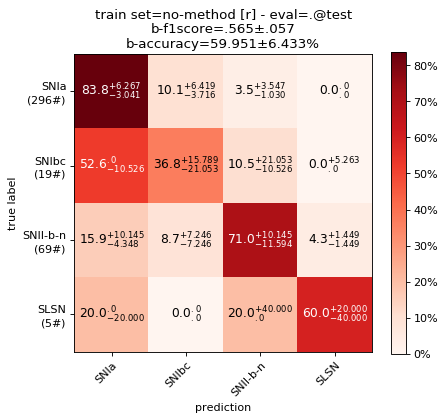

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0507
[2#] LinearTrend_g=.0416
[3#] SPM_t0_r=.0413
[4#] SPM_gamma_r=.0407
[5#] LinearTrend_r=.0388
[6#] Meanvariance_r=.0273
[7#] SPM_gamma_g=.0265
[8#] SPM_tau_rise_r=.0261
[9#] ExcessVar_r=.0247
[10#] SPM_beta_r=.0226
(50, 4, 4)


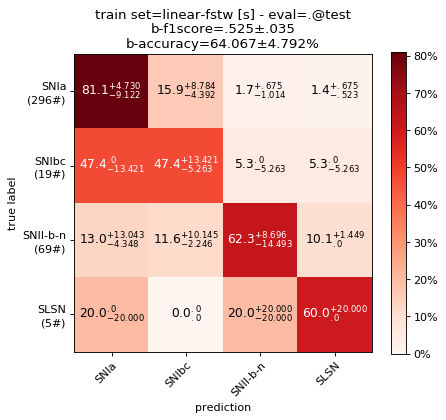

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0724
[2#] SPM_t0_r=.0535
[3#] LinearTrend_g=.0467
[4#] LinearTrend_r=.0414
[5#] SPM_gamma_r=.0355
[6#] SPM_tau_rise_r=.0309
[7#] PairSlopeTrend_g=.0264
[8#] Meanvariance_r=.0253
[9#] SPM_gamma_g=.0252
[10#] SPM_tau_fall_g=.0231
(50, 4, 4)


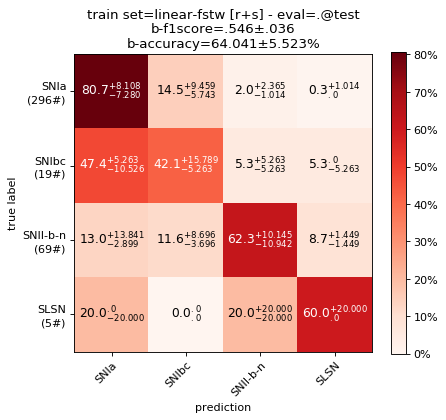

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0650
[2#] SPM_t0_r=.0493
[3#] LinearTrend_g=.0481
[4#] LinearTrend_r=.0434
[5#] SPM_gamma_r=.0382
[6#] Meanvariance_r=.0282
[7#] ExcessVar_r=.0268
[8#] SPM_gamma_g=.0264
[9#] SPM_tau_rise_r=.0260
[10#] PairSlopeTrend_g=.0243
==============================bspline-fstw
(50, 4, 4)


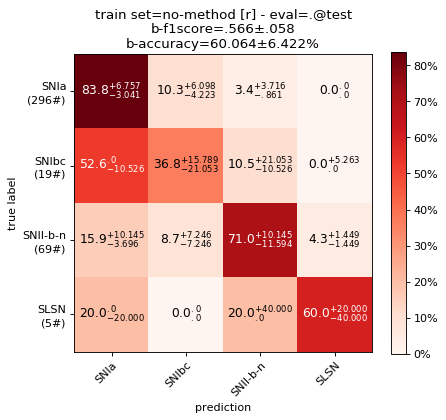

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0491
[2#] SPM_t0_r=.0399
[3#] LinearTrend_g=.0396
[4#] SPM_gamma_r=.0395
[5#] LinearTrend_r=.0376
[6#] Meanvariance_r=.0281
[7#] ExcessVar_r=.0275
[8#] SPM_tau_rise_r=.0259
[9#] SPM_gamma_g=.0255
[10#] SPM_tau_fall_r=.0221
(50, 4, 4)


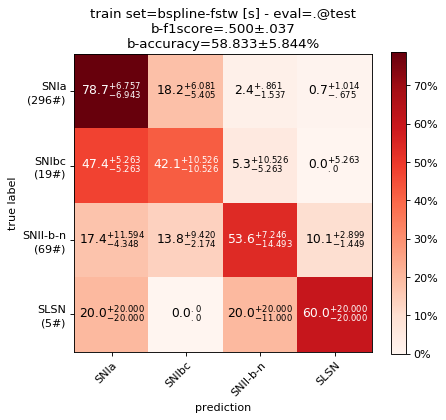

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0688
[2#] LinearTrend_g=.0507
[3#] SPM_t0_r=.0446
[4#] LinearTrend_r=.0373
[5#] SPM_gamma_r=.0360
[6#] SPM_gamma_g=.0299
[7#] SPM_tau_rise_r=.0296
[8#] Meanvariance_r=.0295
[9#] ExcessVar_r=.0284
[10#] PairSlopeTrend_g=.0201
(50, 4, 4)


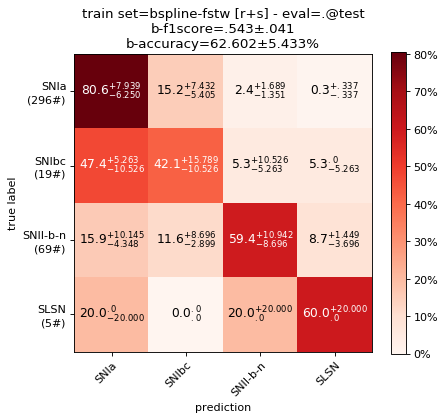

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0611
[2#] LinearTrend_g=.0491
[3#] SPM_t0_r=.0442
[4#] LinearTrend_r=.0423
[5#] SPM_gamma_r=.0372
[6#] Meanvariance_r=.0307
[7#] ExcessVar_r=.0304
[8#] SPM_gamma_g=.0299
[9#] SPM_tau_rise_r=.0257
[10#] PairSlopeTrend_g=.0231
==============================spm-mle-fstw
(50, 4, 4)


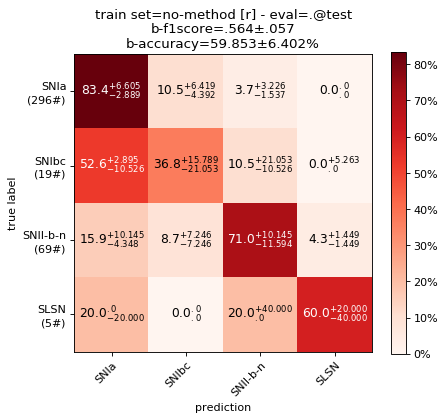

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0503
[2#] LinearTrend_g=.0458
[3#] SPM_gamma_r=.0400
[4#] SPM_t0_r=.0395
[5#] LinearTrend_r=.0379
[6#] Meanvariance_r=.0287
[7#] ExcessVar_r=.0258
[8#] SPM_gamma_g=.0254
[9#] SPM_tau_rise_r=.0242
[10#] SPM_beta_r=.0231
(50, 4, 4)


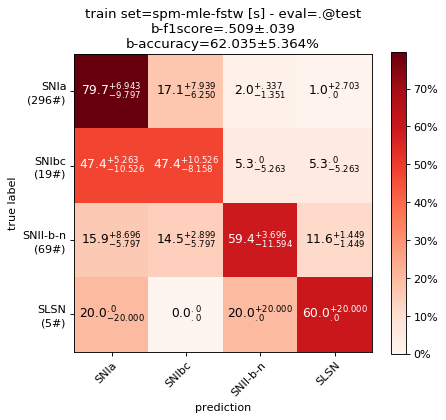

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0638
[2#] LinearTrend_g=.0474
[3#] SPM_t0_r=.0471
[4#] SPM_gamma_r=.0405
[5#] LinearTrend_r=.0375
[6#] PairSlopeTrend_g=.0353
[7#] SPM_tau_rise_r=.0282
[8#] SPM_gamma_g=.0255
[9#] Meanvariance_r=.0248
[10#] ExcessVar_r=.0245
(50, 4, 4)


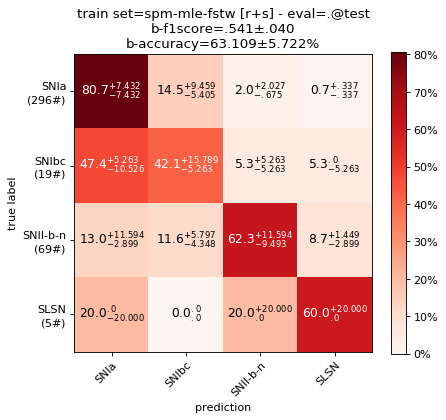

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0629
[2#] LinearTrend_g=.0482
[3#] SPM_t0_r=.0464
[4#] SPM_gamma_r=.0415
[5#] LinearTrend_r=.0389
[6#] PairSlopeTrend_g=.0276
[7#] Meanvariance_r=.0271
[8#] SPM_gamma_g=.0266
[9#] SPM_tau_rise_r=.0247
[10#] ExcessVar_r=.0246
==============================spm-mcmc-fstw
(50, 4, 4)


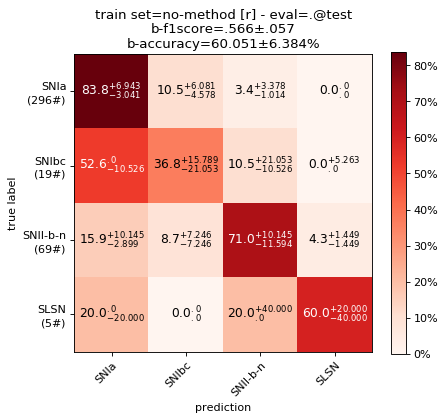

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0480
[2#] LinearTrend_g=.0447
[3#] SPM_gamma_r=.0415
[4#] SPM_t0_r=.0408
[5#] LinearTrend_r=.0379
[6#] Meanvariance_r=.0276
[7#] SPM_gamma_g=.0264
[8#] SPM_tau_rise_r=.0263
[9#] ExcessVar_r=.0254
[10#] SPM_tau_fall_r=.0222
(50, 4, 4)


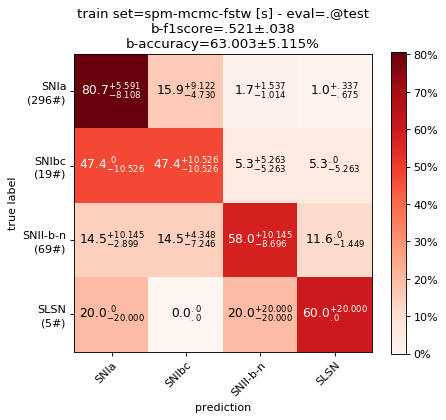

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0681
[2#] SPM_t0_r=.0496
[3#] LinearTrend_g=.0460
[4#] SPM_gamma_r=.0445
[5#] LinearTrend_r=.0347
[6#] SPM_gamma_g=.0304
[7#] SPM_tau_rise_r=.0273
[8#] PairSlopeTrend_g=.0258
[9#] Meanvariance_r=.0247
[10#] ExcessVar_r=.0236
(50, 4, 4)


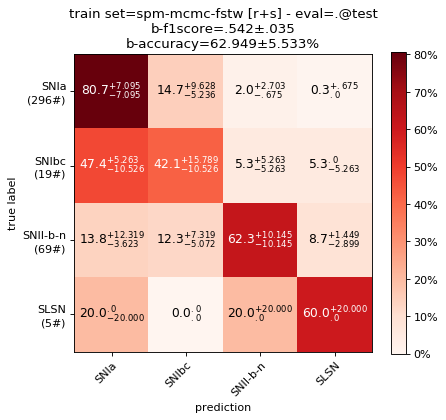

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0618
[2#] SPM_t0_r=.0488
[3#] LinearTrend_g=.0454
[4#] SPM_gamma_r=.0421
[5#] LinearTrend_r=.0378
[6#] SPM_gamma_g=.0285
[7#] Meanvariance_r=.0278
[8#] SPM_tau_rise_r=.0266
[9#] ExcessVar_r=.0253
[10#] SPM_tau_fall_g=.0233
==============================spm-mle-estw
(50, 4, 4)


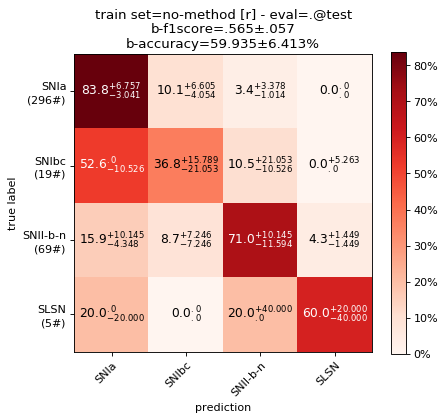

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0520
[2#] LinearTrend_g=.0432
[3#] SPM_gamma_r=.0405
[4#] SPM_t0_r=.0404
[5#] LinearTrend_r=.0393
[6#] Meanvariance_r=.0274
[7#] SPM_gamma_g=.0264
[8#] ExcessVar_r=.0263
[9#] SPM_tau_rise_r=.0253
[10#] SPM_beta_r=.0219
(50, 4, 4)


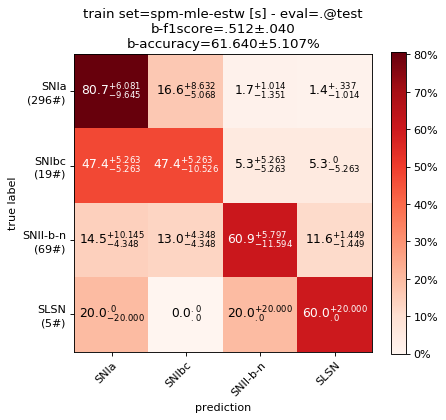

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0716
[2#] SPM_t0_r=.0515
[3#] LinearTrend_g=.0449
[4#] SPM_gamma_r=.0386
[5#] LinearTrend_r=.0355
[6#] PairSlopeTrend_g=.0330
[7#] SPM_tau_rise_r=.0267
[8#] Meanvariance_r=.0247
[9#] ExcessVar_r=.0241
[10#] PercentAmplitude_r=.0236
(50, 4, 4)


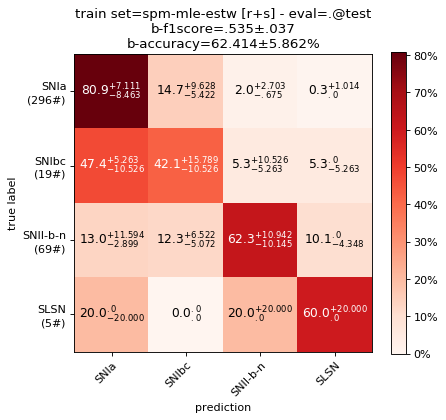

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0646
[2#] LinearTrend_g=.0476
[3#] SPM_t0_r=.0461
[4#] SPM_gamma_r=.0391
[5#] LinearTrend_r=.0379
[6#] Meanvariance_r=.0281
[7#] SPM_tau_rise_r=.0274
[8#] PairSlopeTrend_g=.0265
[9#] SPM_gamma_g=.0262
[10#] ExcessVar_r=.0256
==============================spm-mcmc-estw
(50, 4, 4)


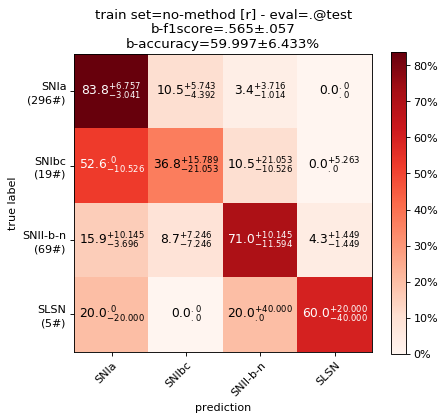

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0505
[2#] LinearTrend_g=.0426
[3#] SPM_gamma_r=.0418
[4#] SPM_t0_r=.0399
[5#] LinearTrend_r=.0363
[6#] Meanvariance_r=.0271
[7#] SPM_gamma_g=.0263
[8#] SPM_tau_rise_r=.0259
[9#] ExcessVar_r=.0257
[10#] SPM_beta_r=.0222
(50, 4, 4)


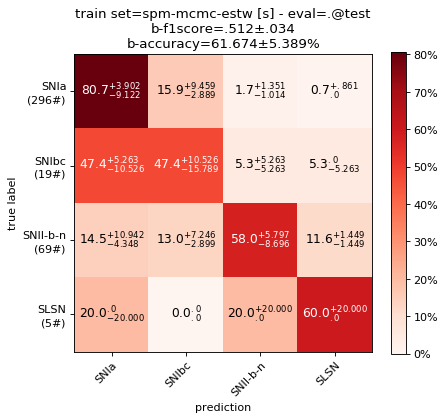

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0674
[2#] LinearTrend_g=.0510
[3#] SPM_t0_r=.0446
[4#] SPM_gamma_r=.0399
[5#] LinearTrend_r=.0362
[6#] SPM_tau_rise_r=.0292
[7#] PairSlopeTrend_g=.0292
[8#] SPM_gamma_g=.0282
[9#] SPM_tau_fall_r=.0249
[10#] Meanvariance_r=.0248
(50, 4, 4)


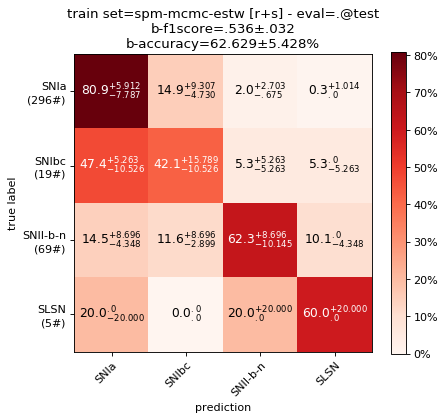

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0629
[2#] LinearTrend_g=.0505
[3#] LinearTrend_r=.0411
[4#] SPM_t0_r=.0408
[5#] SPM_gamma_r=.0396
[6#] SPM_tau_rise_r=.0286
[7#] SPM_gamma_g=.0283
[8#] Meanvariance_r=.0269
[9#] ExcessVar_r=.0259
[10#] SPM_tau_fall_g=.0239


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

mode = 'sne' # all sne
methods = [
    'linear-fstw',
    'bspline-fstw',
    'spm-mle-fstw',
    'spm-mcmc-fstw',
    'spm-mle-estw',
    'spm-mcmc-estw',
]
#methods = ['spm-mcmc-estw']
eval_lcset_name = 'test' # val test
kf = '.'

for method in methods:
    print('='*30+method)
    #for train_config in ['r', 's']:
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        f1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])
        accuracy_xe = XError([f()['metrics_dict']['b-accuracy'] for f in files])
        print(cms.shape)

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'train set={_title} - eval={kf}@{eval_lcset_name}'+'\n'
        title += f'b-f1score={f1score_xe}'+'\n'
        title += f'b-accuracy={accuracy_xe}%'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #print(files[0]()['features'])
        plt.show()
        print(class_names)
        print(files[0]()['rank'])
        df = files[0]()['wrongs_df']
        #display(df[df['_y']==0])
        #display(df[df['_y']==2])

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

metrics = [
    'b-accuracy',
    'b-f1score',
    'b-gmean',
    #'b-dpower',
    'b-xentropy',
]
info_df = DFBuilder()
for metric in metrics:
    for train_config in ['r', 's', 'r+s']:
    #for train_config in ['r', 's']:
        d = {}
        for method in methods:
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            metric_xe = XError([f()['metrics_dict'][metric] for f in files])
            d[method] = metric_xe
            #print(len(metric_xe))

        info_df.append(f'metric={metric} [{train_config}]', d)
        
latex_kwargs = {
    'caption':f'eval-set={kf}@{eval_lcset_name}',
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
print('% \multicolumn{3}{c|}{}')
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval-set=.@test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc|cc}
\hline
metric & linear-fstw & bspline-fstw & spm-mle-fstw & spm-mcmc-fstw & spm-mle-estw & spm-mcmc-estw \srule\\\hline\hline
b-accuracy [r] & 59.951$\pm$6.433 & 60.064$\pm$6.422 & 59.853$\pm$6.402 & 60.051$\pm$6.384 & 59.935$\pm$6.413 & 59.997$\pm$6.433  \srule\\
b-accuracy [s] & 64.067$\pm$4.792 & 58.833$\pm$5.844 & 62.035$\pm$5.364 & 63.003$\pm$5.115 & 61.640$\pm$5.107 & 61.674$\pm$5.389  \srule\\
b-accuracy [r+s] & 64.041$\pm$5.523 & 62.602$\pm$5.433 & 63.109$\pm$5.722 & 62.949$\pm$5.533 & 62.414$\pm$5.862 & 62.629$\pm$5.428  \srule\\
\hline
b-f1score [r] & .565$\pm$.057 & .566$\pm$.058 & .564$\pm$.057 & .566$\pm$.057 & .565$\pm$.057 & .565$\pm$.05

,linear-fstw,bspline-fstw,spm-mle-fstw,spm-mcmc-fstw,spm-mle-estw,spm-mcmc-estw
metric=b-accuracy [r],59.951±6.433,60.064±6.422,59.853±6.402,60.051±6.384,59.935±6.413,59.997±6.433
metric=b-accuracy [s],64.067±4.792,58.833±5.844,62.035±5.364,63.003±5.115,61.640±5.107,61.674±5.389
metric=b-accuracy [r+s],64.041±5.523,62.602±5.433,63.109±5.722,62.949±5.533,62.414±5.862,62.629±5.428
metric=b-f1score [r],.565±.057,.566±.058,.564±.057,.566±.057,.565±.057,.565±.057
metric=b-f1score [s],.525±.035,.500±.037,.509±.039,.521±.038,.512±.040,.512±.034
metric=b-f1score [r+s],.546±.036,.543±.041,.541±.040,.542±.035,.535±.037,.536±.032
metric=b-gmean [r],.713±.048,.714±.047,.712±.047,.714±.047,.713±.048,.713±.048
metric=b-gmean [s],.749±.037,.708±.044,.735±.039,.741±.037,.733±.037,.732±.039
metric=b-gmean [r+s],.749±.043,.739±.040,.743±.043,.741±.042,.737±.044,.740±.041
metric=b-xentropy [r],1.043±.070,1.043±.069,1.042±.070,1.043±.070,1.044±.069,1.042±.070


In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        rank = files[0]()['rank']
        #print(rank)
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.3f}%)'

    info_df.append(f'rank={k+1}', d)

latex_kwargs = {
    'caption':f'eval-set={kf}@{eval_lcset_name}',
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    #'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval-set=.@test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc|cc}
\hline
rank & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mle-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mle-estw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-g (6.507\%) & SPM-t0-g (6.115\%) & SPM-t0-g (6.294\%) & SPM-t0-g (6.181\%) & SPM-t0-g (6.470\%) & SPM-t0-g (6.297\%)  \srule\\
2 & SPM-t0-r (4.936\%) & LinearTrend-g (4.920\%) & LinearTrend-g (4.822\%) & SPM-t0-r (4.882\%) & LinearTrend-g (4.763\%) & LinearTrend-g (5.059\%)  \srule\\
3 & LinearTrend-g (4.811\%) & SPM-t0-r (4.424\%) & SPM-t0-r (4.646\%) & LinearTrend-g (4.547\%) & SPM-t0-r (4.619\%) & LinearTrend-r (4.113\%)  \srule\\
4 & LinearTrend-r (4.345\%) & LinearTrend-r (4.234\

,linear-fstw [r+s],bspline-fstw [r+s],spm-mle-fstw [r+s],spm-mcmc-fstw [r+s],spm-mle-estw [r+s],spm-mcmc-estw [r+s]
rank=1,SPM-t0-g (6.507%),SPM-t0-g (6.115%),SPM-t0-g (6.294%),SPM-t0-g (6.181%),SPM-t0-g (6.470%),SPM-t0-g (6.297%)
rank=2,SPM-t0-r (4.936%),LinearTrend-g (4.920%),LinearTrend-g (4.822%),SPM-t0-r (4.882%),LinearTrend-g (4.763%),LinearTrend-g (5.059%)
rank=3,LinearTrend-g (4.811%),SPM-t0-r (4.424%),SPM-t0-r (4.646%),LinearTrend-g (4.547%),SPM-t0-r (4.619%),LinearTrend-r (4.113%)
rank=4,LinearTrend-r (4.345%),LinearTrend-r (4.234%),SPM-gamma-r (4.159%),SPM-gamma-r (4.216%),SPM-gamma-r (3.915%),SPM-t0-r (4.082%)
rank=5,SPM-gamma-r (3.825%),SPM-gamma-r (3.725%),LinearTrend-r (3.897%),LinearTrend-r (3.789%),LinearTrend-r (3.797%),SPM-gamma-r (3.966%)
rank=6,Meanvariance-r (2.829%),Meanvariance-r (3.077%),PairSlopeTrend-g (2.763%),SPM-gamma-g (2.853%),Meanvariance-r (2.818%),SPM-tau-rise-r (2.866%)
rank=7,ExcessVar-r (2.689%),ExcessVar-r (3.044%),Meanvariance-r (2.719%),Meanvariance-r (2.781%),SPM-tau-rise-r (2.744%),SPM-gamma-g (2.840%)
rank=8,SPM-gamma-g (2.646%),SPM-gamma-g (3.000%),SPM-gamma-g (2.660%),SPM-tau-rise-r (2.662%),PairSlopeTrend-g (2.656%),Meanvariance-r (2.691%)
rank=9,SPM-tau-rise-r (2.601%),SPM-tau-rise-r (2.575%),SPM-tau-rise-r (2.473%),ExcessVar-r (2.538%),SPM-gamma-g (2.623%),ExcessVar-r (2.598%)
rank=10,PairSlopeTrend-g (2.438%),PairSlopeTrend-g (2.313%),ExcessVar-r (2.467%),SPM-tau-fall-g (2.337%),ExcessVar-r (2.561%),SPM-tau-fall-g (2.396%)
